<a href="https://colab.research.google.com/github/aniket-alt/crispdm-kdd-semma-ds/blob/main/project_3_semma_bean_classification/Dry_Bean_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Mount Drive, Install Libraries, and Load Data

# --- 1. Install openpyxl (needed for pandas to read .xlsx files) ---
!pip install openpyxl

# --- 2. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- 3. Mount Google Drive ---
drive.mount('/content/drive')

# --- 4. Load the Data ---
# This is the first part of the SEMMA "Sample" step (getting the data)
file_path = '/content/drive/My Drive/Coursework/Data Mining/Assignments/SEMMA/Dry_Bean_Dataset.xlsx'

try:
    df = pd.read_excel(file_path)
    print("✅ Data loaded successfully!")
    print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
    print("\n--- Initial Data Head ---")
    print(df.head())
except FileNotFoundError:
    print(f"❌ ERROR: File not found at the path: {file_path}")
    print("Please make sure 'Dry_Bean_Dataset.xlsx' is in your main 'My Drive' folder.")

Mounted at /content/drive
✅ Data loaded successfully!
Dataset has 13611 rows and 17 columns.

--- Initial Data Head ---
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.9

In [2]:
# Cell 2: SEMMA Step 1: Sample (Partitioning the Data)
print("--- SEMMA Step 1: Sample ---")

# First, define our features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Create the initial 70% Training Sample
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the remaining 30% into 15% Validation and 15% Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Total data: {len(df)} rows")
print(f"Training Sample: {len(X_train)} rows (~70%)")
print(f"Validation Sample: {len(X_val)} rows (~15%)")
print(f"Test Sample: {len(X_test)} rows (~15%)")
print("✅ Data successfully partitioned into 3 samples.")

--- SEMMA Step 1: Sample ---
Total data: 13611 rows
Training Sample: 9527 rows (~70%)
Validation Sample: 2042 rows (~15%)
Test Sample: 2042 rows (~15%)
✅ Data successfully partitioned into 3 samples.


--- SEMMA Step 2: Explore ---

--- Target Variable Distribution ---
Class
DERMASON    0.260523
SIRA        0.193660
SEKER       0.148945
HOROZ       0.141703
CALI        0.119765
BARBUNYA    0.097092
BOMBAY      0.038312
Name: proportion, dtype: float64


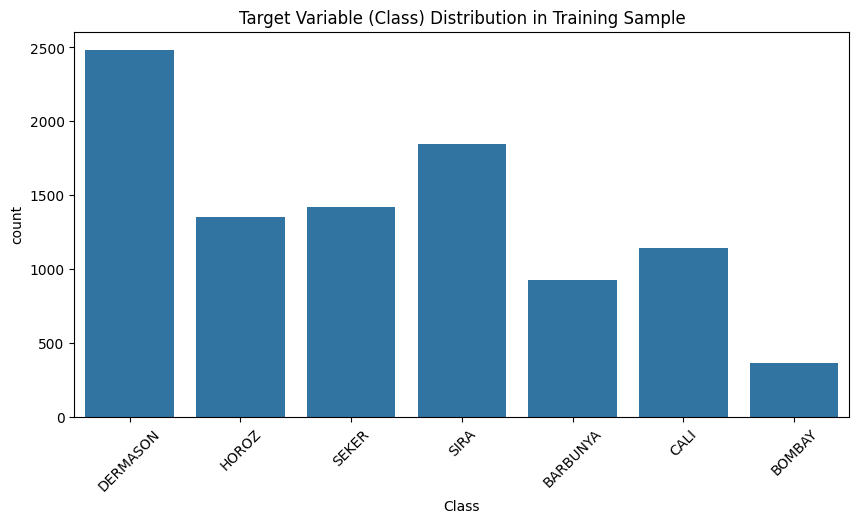


--- Feature Scales (from Training Sample) ---
                Area    Perimeter  MajorAxisLength  MinorAxisLength  \
count    9527.000000  9527.000000      9527.000000      9527.000000   
mean    52969.300619   854.654448       319.889593       202.158035   
std     29244.521479   213.716254        85.445223        44.895723   
min     20420.000000   524.736000       183.601165       122.512653   
25%     36253.000000   702.701500       253.066105       175.706979   
50%     44691.000000   795.147000       297.398542       192.467288   
75%     61311.000000   976.030500       375.897556       216.449332   
max    248424.000000  1895.940000       726.373493       460.198497   

       AspectRation  Eccentricity     ConvexArea  EquivDiameter       Extent  \
count   9527.000000   9527.000000    9527.000000    9527.000000  9527.000000   
mean       1.582808      0.750886   53689.755747     252.894574     0.749464   
std        0.246015      0.091677   29690.440866      59.053439     0.049

In [3]:
# Cell 3: SEMMA Step 2: Explore
print("--- SEMMA Step 2: Explore ---")

# 1. Explore Target Variable 'Class' (Imbalance Check)
print("\n--- Target Variable Distribution ---")
print(y_train.value_counts(normalize=True))
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Target Variable (Class) Distribution in Training Sample')
plt.xticks(rotation=45)
plt.show()

# 2. Explore Feature Scales
print("\n--- Feature Scales (from Training Sample) ---")
print(X_train.describe())
# This table clearly shows the "Explore" discovery:
# 'Area' is in the 10,000s, 'Eccentricity' is < 1.
# This confirms scaling is necessary.

# 3. Explore Missing Values
print("\n--- Missing Values Check ---")
print(X_train.isnull().sum().any())
# The result 'False' means "No, there are no columns with missing values."
print("✅ No missing values found in the dataset.")

In [4]:
# Cell 4: SEMMA Step 3: Modify
print("--- SEMMA Step 3: Modify ---")

# 1. Modify Numerical Features (Scaling)
# Based on our "Explore" discovery, we apply StandardScaler.
# We create a list of all numeric features (which is all features in X)
numeric_features = X_train.columns

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the Training Sample
scaler.fit(X_train)

# Transform all three samples
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Numerical features (X) successfully scaled.")

# 2. Modify Target Variable (Label Encoding)
# Initialize the encoder
le = LabelEncoder()

# Fit the encoder ONLY on the Training Target
le.fit(y_train)

# Transform all three target samples
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

print("✅ Target variable (y) successfully label-encoded.")
print(f"Example: '{y_test.iloc[0]}' -> {y_test_encoded[0]}")
print(f"Classes: {le.classes_}")

--- SEMMA Step 3: Modify ---
✅ Numerical features (X) successfully scaled.
✅ Target variable (y) successfully label-encoded.
Example: 'HOROZ' -> 4
Classes: ['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


In [5]:
# Cell 5: SEMMA Step 4: Model
print("--- SEMMA Step 4: Model ---")

# Initialize our three candidate models
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train all models on the MODIFIED Training Sample
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train_encoded)

print("--- All models trained! ---")

# (Note: In a real-world scenario, we would use the X_val_scaled
# data here to tune hyperparameters, like the 'n_neighbors' for KNN.
# For this assignment, we will skip tuning and move to Assessment.)

--- SEMMA Step 4: Model ---
Training K-Nearest Neighbors...
Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Random Forest...
--- All models trained! ---


--- SEMMA Step 5: Assess ---
Assessing models on the final 15% Test Sample...

=================== K-Nearest Neighbors ===================
Accuracy: 0.9163
F1-Score (Macro): 0.9297

=================== Logistic Regression ===================
Accuracy: 0.9202
F1-Score (Macro): 0.9327

=================== Random Forest ===================
Accuracy: 0.9192
F1-Score (Macro): 0.9309

--- Best Model Selected: LogisticRegression ---
Generating final Confusion Matrix for the best model...


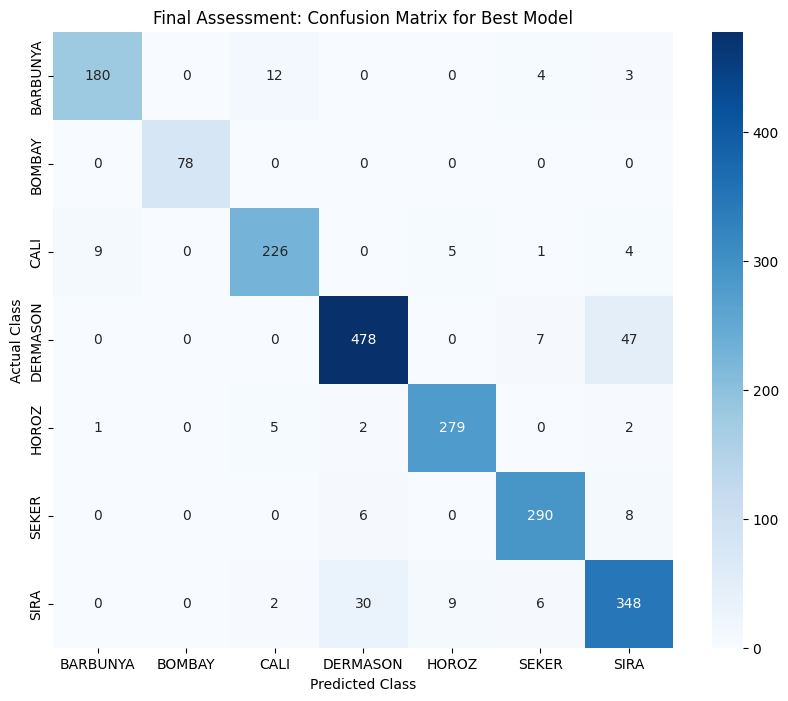


--- Final Classification Report (Best Model) ---
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.90      0.93       199
      BOMBAY       1.00      1.00      1.00        78
        CALI       0.92      0.92      0.92       245
    DERMASON       0.93      0.90      0.91       532
       HOROZ       0.95      0.97      0.96       289
       SEKER       0.94      0.95      0.95       304
        SIRA       0.84      0.88      0.86       395

    accuracy                           0.92      2042
   macro avg       0.93      0.93      0.93      2042
weighted avg       0.92      0.92      0.92      2042


--- Project 3 (SEMMA) Complete ---


In [6]:
# Cell 6: SEMMA Step 5: Assess
print("--- SEMMA Step 5: Assess ---")
print("Assessing models on the final 15% Test Sample...")

best_model = None
best_f1 = -1

# Get the class names from our LabelEncoder for the reports
class_names = le.classes_

for name, model in models.items():
    print(f"\n=================== {name} ===================")

    # Make predictions on the unseen Test Sample
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    # 'macro' average calculates F1 for each class, then averages. Good for imbalance.
    f1 = f1_score(y_test_encoded, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")

    # Keep track of the best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

print(f"\n--- Best Model Selected: {best_model.__class__.__name__} ---")

# --- Final Assessment: Confusion Matrix for Best Model ---
print("Generating final Confusion Matrix for the best model...")
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test_encoded, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Final Assessment: Confusion Matrix for Best Model')
plt.show()

# You can also print the full classification report
print("\n--- Final Classification Report (Best Model) ---")
print(classification_report(y_test_encoded, y_pred_best, target_names=class_names))

print("\n--- Project 3 (SEMMA) Complete ---")